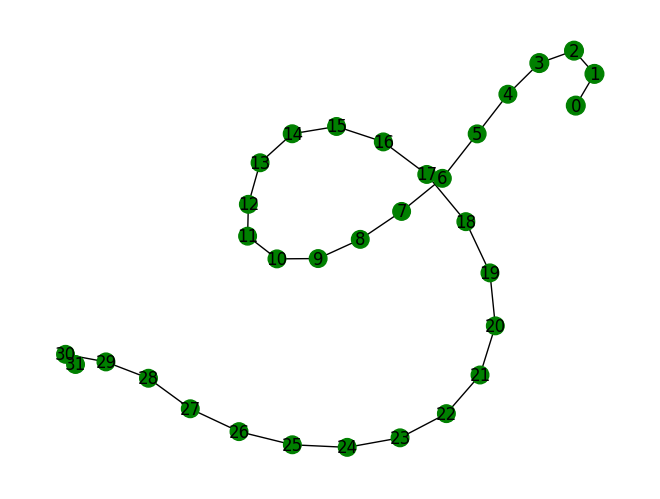

In [1]:
from disqco.circuits.cp_fraction import cp_fraction, cz_fraction
from disqco.graphs.GCP_hypergraph import QuantumCircuitHyperGraph
from qiskit import transpile
from disqco.parti.FM.FM_methods import set_initial_partitions
from disqco.circuits.QAOA import QAOA_random
from qiskit.circuit.library import QFT, QuantumVolume  
import pickle

num_qubits = 256

# circuit = QAOA_random(num_qubits, prob = 0.5, reps = 1)
# circuit = QFT(num_qubits,do_swaps = False)

circuit = cp_fraction(  num_qubits=num_qubits,
                        depth=num_qubits,
                        fraction= 0.5)

# with open("circuit.pkl", "wb") as f:
#     pickle.dump(circuit, f)

# circuit = QuantumVolume(num_qubits, depth = 16)

# with open("circuit.pkl", "rb") as f:
#     circuit = pickle.load(f)

# circuit = cz_fraction(  num_qubits=num_qubits,
                        # depth=num_qubits,
                        # fraction= 0.5)

# from QASMBench.interface.qiskit import QASMBenchmark

# # path to the root directory of QASMBench
# path = "QASMBench"
# # selected category for QASMBench
# category = "large" 
# # select only the circuits with the number of qubits in the list
# num_qubits_list = list(range(3, 200))
# # whether to remove the final measurement in the circuit
# remove_final_measurements = True
# # whether to use qiskit.transpile() to transpile the circuits (note: must provide qiskit backend)
# do_transpile = True  # Changed to True for transpiling circuits
# # arguments for qiskit.transpile(). backend should be provided at least
# transpile_args = { 'basis_gates': ['u', 'cp']}
# bm = QASMBenchmark(path, category, num_qubits_list=num_qubits_list, do_transpile=do_transpile, **transpile_args, remove_final_measurements=remove_final_measurements)
# for circuit in bm.circ_name_list:
#     print(circuit)
# circuit = bm.get('cc_n64')

circuit = transpile(circuit, basis_gates = ['cp', 'u'])

# num_qubits = circuit.num_qubits

# print("Number of qubits:", num_qubits)


num_partitions = 32


import math

def create_grid_coupling(N):
    """
    Create an adjacency list for a grid-like connection of N nodes.

    If N is a perfect square, it uses sqrt(N) x sqrt(N).
    Otherwise, it finds rows x cols such that rows * cols >= N
    and arranges the nodes accordingly.

    Returns:
        A list of edges in the format [[node1, node2], ...].
    """
    # Compute (approx) number of rows and columns
    root = int(math.isqrt(N))  # isqrt gives the integer sqrt floor
    if root * root == N:
        rows, cols = root, root
    else:
        # We want rows * cols >= N, with rows ~ cols ~ sqrt(N)
        # Simple approach: start with rows = int(sqrt(N)) and
        # increment cols until rows * cols >= N.
        rows = root
        # One strategy: determine a minimal 'cols' so that rows * cols >= N
        # If that doesn't work, increment rows as needed.
        if rows * root >= N:
            cols = root
        else:
            cols = root + 1
            if rows * cols < N:  # Still not enough
                rows += 1
    
    edges = []
    node_index = lambda r, c: r * cols + c

    for r in range(rows):
        for c in range(cols):
            current_node = node_index(r, c)
            # Stop if we've reached all N nodes
            if current_node >= N:
                break

            # Connect to the right neighbor if within bounds and within N
            if c < cols - 1:
                right_node = node_index(r, c + 1)
                if right_node < N:
                    edges.append([current_node, right_node])

            # Connect to the bottom neighbor if within bounds and within N
            if r < rows - 1:
                bottom_node = node_index(r + 1, c)
                if bottom_node < N:
                    edges.append([current_node, bottom_node])

    return edges



qpu_sizes = [int(num_qubits/num_partitions)]*num_partitions

qpu_sizes[0] += 1
qpu_sizes[1] += 1
qpu_sizes[2] += 1
qpu_sizes[3] += 1


coupling = [[i, i+1] for i in range(num_partitions-1)]

# coupling = [[i, i+1] for i in range(num_partitions-1)] + [[0, num_partitions-1]]


# coupling = create_grid_coupling(num_partitions)
# coupling = [[i,j] for i in range(int(num_partitions/2)-1) for j in range(int(num_partitions/2)-1) if i != j]

# coupling += [[i,j] for i in range(int(num_partitions/2)+1,num_partitions) for j in range(int(num_partitions/2)+1,num_partitions) if i != j]
# coupling += [[int(num_partitions/2)-2, int(num_partitions/2)-1]]
# coupling += [[int(num_partitions/2)-1, int(num_partitions/2)]]
# coupling += [[int(num_partitions/2), int(num_partitions/2)+1]]

from networkx import erdos_renyi_graph


# graph = erdos_renyi_graph(num_partitions, 0.5)

# coupling = [[i,j] for i in range(num_partitions) for j in range(num_partitions) if i != j and graph.has_edge(i,j)]

# coupling = None
from disqco.graphs.quantum_network import QuantumNetwork

network = QuantumNetwork(qpu_sizes, coupling)

network.draw()



In [2]:
graph = QuantumCircuitHyperGraph(circuit, group_gates = True, anti_diag = True)
assignment = set_initial_partitions(network=network, num_qubits=num_qubits, depth=graph.depth)
print(assignment)

from disqco.parti.FM.FM_methods import get_all_configs, get_all_costs_hetero

if num_partitions <=12:

    configs = get_all_configs(num_partitions, hetero=True)

    costs, edge_tree = get_all_costs_hetero(network, configs)
else:

    costs = {}

print(costs)

[[ 0  0  0 ... 31 31 31]
 [ 0  0  0 ... 31 31 31]
 [ 0  0  0 ... 31 31 31]
 ...
 [ 0  0  0 ... 31 31 31]
 [ 0  0  0 ... 31 31 31]
 [ 0  0  0 ... 31 31 31]]
{}


In [19]:
# from disqco.parti.FM.FM_hetero import run_FM_hetero

# final_cost, final_assignment, cost_list = run_FM_hetero(hypergraph=graph,
#                                                         initial_assignment=assignment,
#                                                         qpu_info=qpu_sizes,
#                                                         num_partitions=num_partitions,
#                                                         network=network,
#                                                         limit=num_qubits,
#                                                         costs=costs,
#                                                         passes=50,
#                                                         log=True)





In [20]:
from disqco.drawing.tikz_drawing import draw_graph_tikz
from disqco.drawing.mpl_drawing import draw_graph_mpl

%load_ext jupyter_tikz

# if num_qubits <= 32:
#     draw_graph_tikz(graph, assignment, qpu_sizes)
# else:
#     if num_qubits <= 64:
#         draw_graph_mpl(graph, assignment, qpu_sizes)

The jupyter_tikz extension is already loaded. To reload it, use:
  %reload_ext jupyter_tikz


In [21]:
# print("Final cost: ", final_cost)
import qiskit
qiskit.__version__

'1.2.4'

In [3]:
from disqco.parti.FM.multilevel_FM import MLFM_recursive_hetero

final_assignment_list, final_cost_list, _ = MLFM_recursive_hetero(graph,
                                                                    assignment,
                                                                    qpu_sizes,
                                                                    limit=num_qubits,
                                                                    network=network,
                                                                    log=True,
                                                                    stochastic=True,
                                                                    costs=costs, 
                                                                    level_limit=4)


Initial cost: 112078
All passes complete.
Final cost: 102123
Best cost at level 0: 102123
Initial cost: 102123


KeyboardInterrupt: 

qpu_info [9, 9, 9, 9, 8, 8, 8, 8]
[{0: [0, 1, 2, 3, 4, 5, 6, 7, 8], 1: [9, 10, 11, 12, 13, 14, 15, 16, 17], 2: [18, 19, 20, 21, 22, 23, 24, 25, 26], 3: [27, 28, 29, 30, 31, 32, 33, 34, 35], 4: [36, 37, 38, 39, 40, 41, 42, 43], 5: [44, 45, 46, 47, 48, 49, 50, 51], 6: [52, 53, 54, 55, 56, 57, 58, 59], 7: [60, 61, 62, 63, 64, 65, 66, 67]}, {0: [0, 1, 2, 3, 4, 5, 6, 7, 8], 1: [9, 10, 11, 12, 13, 14, 15, 16, 17], 2: [18, 19, 20, 21, 22, 23, 24, 25, 26], 3: [27, 28, 29, 30, 31, 32, 33, 34, 35], 4: [36, 37, 38, 39, 40, 41, 42, 43], 5: [44, 45, 46, 47, 48, 49, 50, 51], 6: [52, 53, 54, 55, 56, 57, 58, 59], 7: [60, 61, 62, 63, 64, 65, 66, 67]}, {0: [0, 1, 2, 3, 4, 5, 6, 7, 8], 1: [9, 10, 11, 12, 13, 14, 15, 16, 17], 2: [18, 19, 20, 21, 22, 23, 24, 25, 26], 3: [27, 28, 29, 30, 31, 32, 33, 34, 35], 4: [36, 37, 38, 39, 40, 41, 42, 43], 5: [44, 45, 46, 47, 48, 49, 50, 51], 6: [52, 53, 54, 55, 56, 57, 58, 59], 7: [60, 61, 62, 63, 64, 65, 66, 67]}, {0: [0, 1, 2, 3, 4, 5, 6, 7, 8], 1: [9, 10, 11, 12, 1

KeyboardInterrupt: 

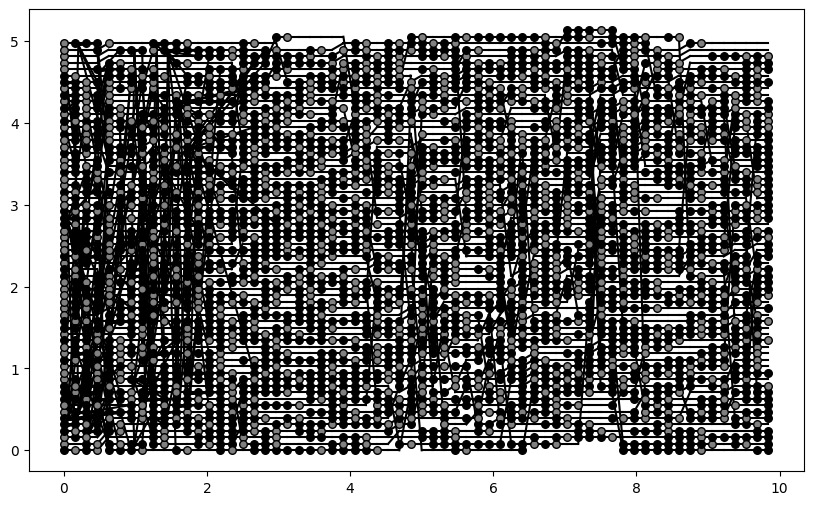

In [ ]:

import numpy as np

final_assignment = final_assignment_list[np.argmin(final_cost_list)]
if num_qubits <= 32:
    fig = draw_graph_tikz(graph, final_assignment, qpu_sizes)
    display(fig)
else:
     draw_graph_mpl(graph, final_assignment, qpu_sizes)

In [ ]:
from disqco.parti.FM.multilevel_FM import MLFM_recursive

list_of_assignments, list_of_costs, _ = MLFM_recursive(
    graph,
    assignment,
    qpu_sizes,
    limit='qubit',
    log=True)

from disqco.graphs.hypergraph_methods import calculate_full_cost_hetero
import numpy as np

best_assignment = list_of_assignments[np.argmin(list_of_costs)]
print("best assignment", best_assignment)
cost_hetero = calculate_full_cost_hetero(graph, best_assignment, num_partitions, costs, network)

print(cost_hetero)

Initial cost: 808
All passes complete.
Final cost: 666
Best cost at level 0: 666
Initial cost: 666
All passes complete.
Final cost: 636
Best cost at level 1: 636
Initial cost: 636
All passes complete.
Final cost: 600
Best cost at level 2: 600
Initial cost: 600
All passes complete.
Final cost: 583
Best cost at level 3: 583
Initial cost: 583
All passes complete.
Final cost: 565
Best cost at level 4: 565
Initial cost: 565
All passes complete.
Final cost: 564
Best cost at level 5: 564
Initial cost: 564
All passes complete.
Final cost: 562
Best cost at level 6: 562
best assignment [[4 4 6 ... 7 1 2]
 [4 7 6 ... 7 1 2]
 [5 7 6 ... 7 1 2]
 ...
 [0 7 7 ... 6 1 4]
 [0 7 7 ... 6 1 4]
 [0 7 7 ... 6 1 4]]
1548


In [ ]:
from disqco.utils.qiskit_to_op_list import circuit_to_gate_layers
layers = circuit_to_gate_layers(circuit)

for layer in layers:
    for gate in layer:
        print(gate)
        # print(gate.qargs)
        # print(gate.op.name)
        # print(gate.op.params)
        # print(gate.op.to_dict())
        # print(gate.op.to_matrix())
        # print(gate.op.to_instruction())
        # print(gate.op.to_gate())
        # print(gate.op.to_circuit())

['u', [0], ['q'], [1.1258204825286438, 4.778845207024915, 1.350304385128597]]
['u', [5], ['q'], [2.7746300657560212, 0.37159250401585436, 1.3654521275910496]]
['u', [6], ['q'], [1.0358605979284323, 1.5942288365933908, 3.4657122853284092]]
['u', [8], ['q'], [1.7922074207634633, 2.45082159261523, 1.1909170419883184]]
['cp', [9, 10], ['q', 'q'], [2.0779524249750367]]
['cp', [12, 11], ['q', 'q'], [0.2510883278361531]]
['u', [14], ['q'], [2.049451072098811, 1.099856797458516, -2.4225133910584358]]
['u', [15], ['q'], [1.411766480763466, 4.2114091871522845, 5.964859748927819]]
['u', [16], ['q'], [1.2658190513890457, 0.5288081136917104, 0.17702279145478217]]
['cp', [4, 17], ['q', 'q'], [4.41141352329542]]
['u', [18], ['q'], [2.736545959138728, 1.6103805201808847, 3.19422555009543]]
['u', [19], ['q'], [0.14326535394414788, 1.0306707236290027, 2.1324705528808945]]
['u', [23], ['q'], [2.8799677572455242, 5.941390429446676, 1.6470618772801626]]
['cp', [24, 22], ['q', 'q'], [2.2022251860854585]]
['